In [163]:
import math
import torch
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import pandas as pd
import numpy as np
import re

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# One-hot encoding

In [165]:
class BasicSmilesTokenizer(object):
  def __init__(self):
    self.regex_pattern = r"""(\[[^\]]+]|Br?|Cl?|Nb?|In?|Sb?|As|Ai|Ta|Ga|O|P|F|H|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
    self.regex = re.compile(self.regex_pattern)

  def tokenize(self, text):
    tokens = [token for token in self.regex.findall(text)]
    return tokens

TOKENIZER = BasicSmilesTokenizer()

In [166]:
vocab = [
    '#', '(', ')', '-', '/', '1', '2', '3', '4', '5', '6', '=', 'Br', 'C', 'Cl',
    'F', 'I', 'In', 'N', 'O', 'P', 'S', '[17O]', '[AlH-]', '[AlH2-]', '[AlH3-]',
    '[AsH3-]', '[BH-]', '[BH2-]', '[BH3-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]',
    '[C@]', '[CH-]', '[CH2-]', '[CH2]', '[CH]', '[C]', '[GaH-]', '[GaH2-]', '[GaH3-]',
    '[InH-]', '[InH2-]', '[InH3-]', '[N+]', '[N-]', '[N@+]', '[N@@+]', '[N@@]', '[N@]',
    '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[NH]', '[N]', '[NbH3-]', '[O+]', '[O-]', '[O]',
    '[PH+]', '[PH3-]', '[PH4-]', '[S+]', '[SbH3-]', '[Si]', '[TaH3-]', '[c-]', '[cH-]',
    '[n+]', '[n-]', '[nH+]', '[nH]', '[o+]', '\\', 'c', 'n', 'o', '[M]',''
]

qm9_augmented = pd.read_csv("Augmented_QM9.csv", index_col=0)
qm9_augmented

/tmp/ipykernel_6190/2346303025.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  qm9_augmented = pd.read_csv("Augmented_QM9.csv", index_col=0)


,SMILES_1,Property_0,parent_idx
0,OC1COC(=N)C1=O,3.49649,-1.0
1,CN(C)C(=O)C=O,3.92544,-1.0
2,C1C2CC3N=COCC123,3.02103,-1.0
3,OC1C2OC3CC2C13O,2.52006,-1.0
4,OC1C2C(=N)OCC12O,2.48587,-1.0
...,...,...,...
267765,CC[M][M]CN1)C1[M]C1C#N,-,18827.0
267766,c1(F)c(ncnc1C)C,-,18827.0
267767,O[M]1C2OC3[M]1C2[M]3=O,-,13501.0
267768,O=C(CN1CCC1)NC,-,13501.0


In [167]:
len(vocab)

82

In [168]:
smiles_list = qm9_augmented['SMILES_1'].tolist()
props = qm9_augmented['Property_0'].tolist()

In [169]:
def one_hot_encode(smiles_list, vocab):
    token_to_index = {token: i for i, token in enumerate(vocab)}
    one_hot_data = []

    for smile in smiles_list:
        tokens = TOKENIZER.tokenize(smile)
        one_hot_seq = []

        for token in tokens:
            vec = np.zeros(len(vocab), dtype=np.float32)
            idx = token_to_index[token]
            vec[idx] = 1.0
            one_hot_seq.append(vec)

        one_hot_seq = np.array(one_hot_seq, dtype=np.float32)
        one_hot_data.append(one_hot_seq)

    return np.array(one_hot_data, dtype=object)

In [170]:
one_hot_encoded = one_hot_encode(smiles_list, vocab)

print(one_hot_encoded[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Definição do modelo contrastivo

## NT-Xent Loss

In [171]:
def nt_xent_loss(out_1, out_2, temperature, eps=1e-6): # diretamente do codigo do Pinheiro

    out = torch.cat([out_1, out_2], dim=0)

    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)
    neg = sim.sum(dim=-1)

    row_sub = torch.Tensor(neg.shape).fill_(
        math.e**(1 / temperature)).to(neg.device)
    neg = torch.clamp(neg - row_sub, min=eps)

    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = torch.log(pos / (neg + eps))
    return -loss.mean(), loss.size(0)

## Definição do encoder

In [172]:
# fiz sem o bidirectional, não sei se é necessário para o meu teste simples 
class SMILESEncoder(torch.nn.Module):
    def __init__(self, vocab_size, max_len, padding_idx, embedding_dim=64, dim=128, num_layers=1):
        super(SMILESEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.embedding_dim = embedding_dim
        self.dim = dim
        self.num_layers = num_layers

        self.encoder = torch.nn.LSTM(self.embedding_dim, self.dim, self.num_layers, batch_first=True)

    def forward(self, x, lengths):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        valid_lengths = torch.clamp(lengths, min=1, max=seq_len)
        
        # Mover lengths para a CPU antes de empacotar
        lengths_on_cpu = valid_lengths.cpu()
        
        x_packed = rnn_utils.pack_padded_sequence(
            x, lengths=lengths_on_cpu, batch_first=True, enforce_sorted=False
        )

        _, (hidden, _) = self.encoder(x_packed)
        return hidden[-1]

## Definição da rede contrastiva

In [173]:
class CLRNet(torch.nn.Module):
    def __init__(self, vocab_size, max_len, padding_idx, embedding_dim=64, dim=128, num_layers=1):
        super(CLRNet, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.embedding_dim = embedding_dim
        self.dim = dim
        self.num_layers = num_layers

        self.emb = torch.nn.Embedding(
            num_embeddings=self.vocab_size, 
            padding_idx=self.padding_idx,
            embedding_dim=self.embedding_dim, 
        )

        # definindo as duas redes LSTM responsáveis pelo aprendizado contrastivo
        self.SMILESEnc1 = SMILESEncoder(vocab_size=self.vocab_size, max_len=self.max_len, padding_idx=self.padding_idx,
                                        embedding_dim=self.embedding_dim, dim=2*self.dim, num_layers=self.num_layers)
        

        self.SMILESEnc2 = SMILESEncoder(vocab_size=self.vocab_size, max_len=self.max_len, padding_idx=self.padding_idx,
                                        embedding_dim=self.embedding_dim, dim=2*self.dim, num_layers=self.num_layers)
        
        # cabeça de projeção MLP
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(2*self.dim, 4 * self.dim),
            torch.nn.BatchNorm1d(4 * self.dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4*self.dim, 6*self.dim, bias=False)
        )
    
    def forward(self, smi, random_smi, smi_len, random_smi_len):
        x = self.emb(smi)
        
        x1 = self.emb(random_smi)
        
        enc1 = self.SMILESEnc1(x, smi_len)
        enc2 = self.SMILESEnc2(x1, random_smi_len)
        
        return F.normalize(self.projection_head(enc1), dim=1), F.normalize(self.projection_head(enc2), dim=1)

In [174]:
max_len = 0
for smile in smiles_list:
    tokens = TOKENIZER.tokenize(smile)
    max_len = max(max_len, len(tokens))

In [175]:
max_len

24

In [176]:
model = CLRNet(vocab_size=len(vocab), max_len=max_len, padding_idx=81)
model = model.to(device)

# Definição do treinamento

In [177]:
def train(model, dataloader, optimizer, device, temperature):
    model.train()
    loss_all = 0
    total_num = 0

    for data in dataloader:
        smi_len = data['random_smi_len1'] 
        random_smi_len = data['random_smi_len2']
        
        smi1 = data['random_smi1'].to(device)
        smi2 = data['random_smi2'].to(device)
        smi_len = smi_len.to(device)
        random_smi_len = random_smi_len.to(device)
        
        optimizer.zero_grad()
        out1, out2 = model(smi1, smi2, smi_len, random_smi_len)
        loss, batch_size = nt_xent_loss(out1, out2, temperature)
        
        loss.backward()  
        
        loss_all += loss.item() * batch_size
        total_num += batch_size
        optimizer.step()

    avg_loss = loss_all / total_num
    print(f"Average training loss: {avg_loss:.4f}")

    return avg_loss

# Separação dos dados em dataloaders

In [178]:
def one_hot_to_indices(one_hot_array):
    return np.argmax(one_hot_array, axis=1)

In [179]:
one_hot_encoded_idx = np.empty(one_hot_encoded.shape, dtype=object)

indexed_sequences = [one_hot_to_indices(seq) for seq in one_hot_encoded]

In [180]:
from torch.utils.data import Dataset

class ContrastiveDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, orig_col='SMILES_1'):
        self.df = df
        self.tokenizer = tokenizer
        self.token_to_index = {token: i for i, token in enumerate(vocab)}
        self.orig_col = orig_col
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        original_smiles = self.df.iloc[idx][self.orig_col]
        
        current_idx = self.df.index[idx]
        
        augmented_rows = self.df[self.df['parent_idx'] == current_idx]
        
        if len(augmented_rows) > 0:
            aug_idx = np.random.randint(len(augmented_rows))
            augmented_smiles = augmented_rows.iloc[aug_idx][self.orig_col]
        else:
            augmented_smiles = original_smiles
            
        orig_tokens = self.tokenizer.tokenize(original_smiles)
        aug_tokens = self.tokenizer.tokenize(augmented_smiles)
        
        orig_indices = [self.token_to_index[token] for token in orig_tokens]
        aug_indices = [self.token_to_index[token] for token in aug_tokens]
        
        return (orig_indices, aug_indices)

In [181]:
def contrastive_collate_fn(batch, padding_idx=81):
    orig_seqs, aug_seqs = zip(*batch)
    
    orig_tensors = [torch.tensor(seq, dtype=torch.long) for seq in orig_seqs]
    aug_tensors = [torch.tensor(seq, dtype=torch.long) for seq in aug_seqs]
    
    orig_lens = [len(seq) for seq in orig_seqs]
    aug_lens = [len(seq) for seq in aug_seqs]
    
    max_orig_len = max(orig_lens)
    max_aug_len = max(aug_lens)
    
    padded_orig = [torch.cat([t, torch.ones(max_orig_len - len(t), dtype=torch.long) * padding_idx]) for t in orig_tensors]
    padded_aug = [torch.cat([t, torch.ones(max_aug_len - len(t), dtype=torch.long) * padding_idx]) for t in aug_tensors]

    orig_batch = torch.stack(padded_orig)
    aug_batch = torch.stack(padded_aug)
    
    orig_lens_tensor = torch.tensor(orig_lens, dtype=torch.long)
    aug_lens_tensor = torch.tensor(aug_lens, dtype=torch.long)
    
    return {
        'random_smi1': orig_batch,
        'random_smi2': aug_batch,
        'random_smi_len1': orig_lens_tensor,
        'random_smi_len2': aug_lens_tensor
    }

In [182]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, val_df = train_test_split(qm9_augmented, test_size=0.2, random_state=42)

train_dataset = ContrastiveDataset(train_df, TOKENIZER, vocab)
val_dataset = ContrastiveDataset(val_df, TOKENIZER, vocab)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    collate_fn=lambda b: contrastive_collate_fn(b, padding_idx=81)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=lambda b: contrastive_collate_fn(b, padding_idx=81)
)

In [183]:
print("Atributos do dataset:")
for attr in dir(train_loader.dataset):
    if not attr.startswith("__"):
        print(f"- {attr}")

print(f"\nTamanho do dataset: {len(train_loader.dataset)}")

first_item = train_loader.dataset[0]
print(f"\nTipo do primeiro item: {type(first_item)}")
print(f"Conteúdo (primeiros elementos):")
for i, seq in enumerate(first_item):
    print(f"Sequência {i+1}: {seq[:10]}... (comprimento: {len(seq)})")

batch = next(iter(train_loader))
print("\nFormato dos dados após collate_fn:")
for key, value in batch.items():
    print(f"- {key}: {type(value)}, shape: {value.shape}")

Atributos do dataset:
- df
- orig_col
- token_to_index
- tokenizer

Tamanho do dataset: 213983

Tipo do primeiro item: <class 'tuple'>
Conteúdo (primeiros elementos):
Sequência 1: [19, 11, 13, 18, 13, 11, 18, 13, 80, 5]... (comprimento: 13)
Sequência 2: [19, 11, 13, 18, 13, 11, 18, 13, 80, 5]... (comprimento: 13)

Formato dos dados após collate_fn:
- random_smi1: <class 'torch.Tensor'>, shape: torch.Size([32, 21])
- random_smi2: <class 'torch.Tensor'>, shape: torch.Size([32, 21])
- random_smi_len1: <class 'torch.Tensor'>, shape: torch.Size([32])
- random_smi_len2: <class 'torch.Tensor'>, shape: torch.Size([32])


In [184]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [185]:
# Fiz o treino na workstation localmente
train(model=model, dataloader=train_loader, optimizer=optimizer, device=device, temperature=0.1)

Average training loss: 0.6376


0.6376294207280307

In [186]:
model = CLRNet(vocab_size=len(vocab), max_len=max_len, padding_idx=81)
model.load_state_dict(torch.load("clr_model.pth"))
model.to(device)

CLRNet(
  (emb): Embedding(82, 64, padding_idx=81)
  (SMILESEnc1): SMILESEncoder(
    (encoder): LSTM(64, 256, batch_first=True)
  )
  (SMILESEnc2): SMILESEncoder(
    (encoder): LSTM(64, 256, batch_first=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=768, bias=False)
  )
)

Average evaluation loss: 0.3210


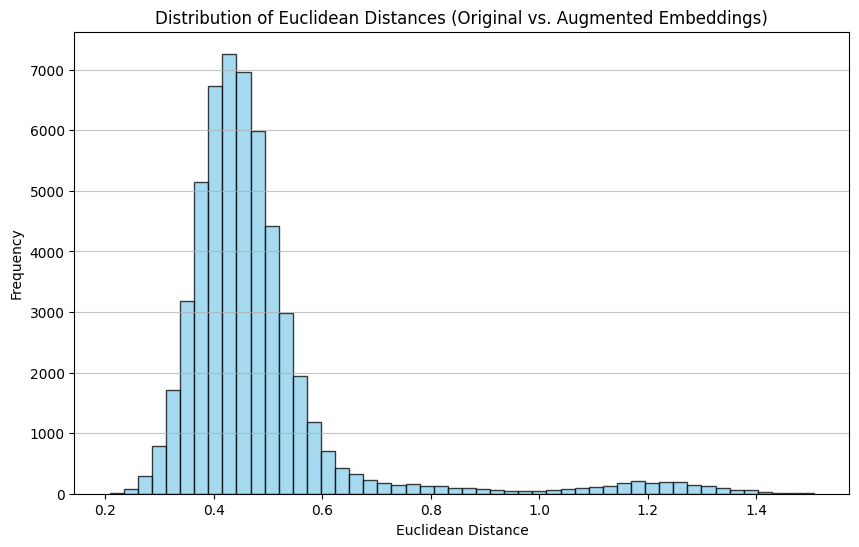


Running t-SNE on 10000 samples (5000 pairs)...


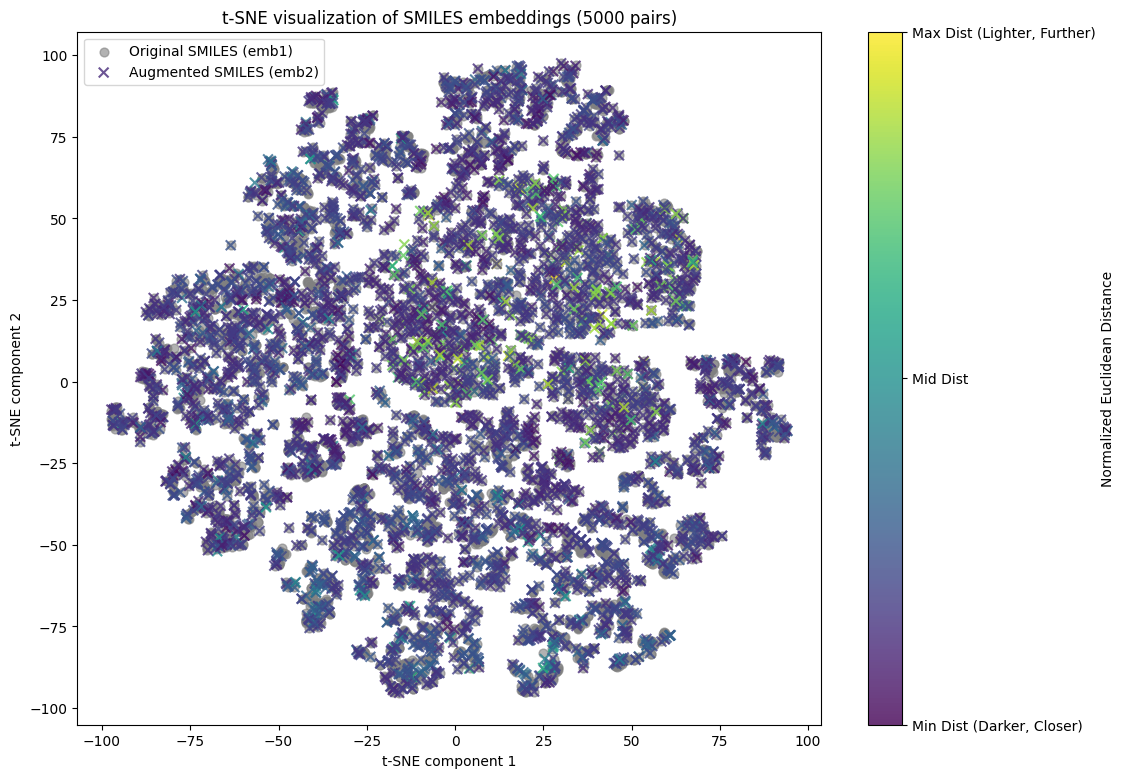

0.32098439389304123

In [188]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import numpy as np 

def evaluate_model(model, dataloader, device, temperature, n_samples_tsne=10000):
    model.eval()  
    total_loss = 0
    total_samples = 0
    
    all_embeddings1_batches = [] 
    all_embeddings2_batches = [] 
    all_distances_for_tsne_batches = [] 
    all_distances_for_histogram = [] 

    with torch.no_grad():  
        for i, data in enumerate(dataloader):
            smi1 = data['random_smi1'].to(device)
            smi2 = data['random_smi2'].to(device)
            smi_len = data['random_smi_len1'].to(device)
            random_smi_len = data['random_smi_len2'].to(device)
            
            out1, out2 = model(smi1, smi2, smi_len, random_smi_len)
            loss, batch_size = nt_xent_loss(out1, out2, temperature)
            
            distances = F.pairwise_distance(out1, out2) 
            all_distances_for_histogram.extend(distances.cpu().numpy())

            total_loss += loss.item() * batch_size
            total_samples += batch_size

            if n_samples_tsne > 0:
                num_collected_samples_for_tsne1 = sum(e.shape[0] for e in all_embeddings1_batches)
                if num_collected_samples_for_tsne1 < n_samples_tsne:
                    all_embeddings1_batches.append(out1.cpu())
                    all_embeddings2_batches.append(out2.cpu())
                    all_distances_for_tsne_batches.append(distances.cpu())
            
    avg_loss = total_loss / total_samples
    print(f"Average evaluation loss: {avg_loss:.4f}")

    # Plotar histograma de distâncias
    if all_distances_for_histogram:
        plt.figure(figsize=(10, 6))
        plt.hist(np.array(all_distances_for_histogram), bins=50, alpha=0.75, color='skyblue', edgecolor='black')
        plt.title('Distribution of Euclidean Distances (Original vs. Augmented Embeddings)')
        plt.xlabel('Euclidean Distance')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("\nNo distances collected to plot histogram.")

    # Plotar t-SNE com coloração por distância
    if n_samples_tsne > 0 and all_embeddings1_batches:
        embeddings1_cat = torch.cat(all_embeddings1_batches, dim=0)
        embeddings2_cat = torch.cat(all_embeddings2_batches, dim=0)
        distances_cat = torch.cat(all_distances_for_tsne_batches, dim=0)
        
        max_pairs_from_collected = embeddings1_cat.size(0)
        num_pairs_for_tsne = min(n_samples_tsne // 2 if n_samples_tsne > 0 else max_pairs_from_collected, max_pairs_from_collected)

        if num_pairs_for_tsne > 1: 
            embeddings1_tsne_input = embeddings1_cat[:num_pairs_for_tsne]
            embeddings2_tsne_input = embeddings2_cat[:num_pairs_for_tsne]
            distances_for_coloring = distances_cat[:num_pairs_for_tsne].numpy()

            combined_embeddings = torch.cat([embeddings1_tsne_input, embeddings2_tsne_input], dim=0).numpy()
            
            print(f"\nRunning t-SNE on {combined_embeddings.shape[0]} samples ({num_pairs_for_tsne} pairs)...")
            
            perplexity_val = min(30, combined_embeddings.shape[0] - 1)
            if perplexity_val <= 1:
                print(f"Warning: Perplexity for t-SNE is too low ({perplexity_val}). Skipping t-SNE plot.")
            else:
                tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val) 
                embeddings_tsne = tsne.fit_transform(combined_embeddings)
                
                out1_tsne = embeddings_tsne[:num_pairs_for_tsne]
                out2_tsne = embeddings_tsne[num_pairs_for_tsne:]
                
                # Normalizar distâncias para coloração (0 a 1)
                min_dist = distances_for_coloring.min()
                max_dist = distances_for_coloring.max()
                if max_dist == min_dist:
                    norm_distances = np.ones_like(distances_for_coloring) * 0.5 
                    print("Note: All distances for t-SNE coloring are identical.")
                else:
                    norm_distances = (distances_for_coloring - min_dist) / (max_dist - min_dist)
                
                plt.figure(figsize=(12, 9)) 
                plt.scatter(out1_tsne[:, 0], out1_tsne[:, 1], label='Original SMILES (emb1)', alpha=0.6, marker='o', s=40, c='gray')
                scatter_aug = plt.scatter(out2_tsne[:, 0], out2_tsne[:, 1], label='Augmented SMILES (emb2)', alpha=0.8, marker='x', s=50, c=norm_distances, cmap='viridis')

                plt.title(f't-SNE visualization of SMILES embeddings ({num_pairs_for_tsne} pairs)')
                plt.xlabel('t-SNE component 1')
                plt.ylabel('t-SNE component 2')
                plt.legend()
                
                cbar = plt.colorbar(scatter_aug, label='Normalized Euclidean Distance')
                cbar.set_ticks([0, 0.5, 1])
                cbar.set_ticklabels(['Min Dist (Darker, Closer)', 'Mid Dist', 'Max Dist (Lighter, Further)'])
                
                plt.show()
        else:
            print(f"\nNot enough pairs ({num_pairs_for_tsne}) collected for t-SNE plot (need > 1 pair).")
    elif n_samples_tsne > 0:
        print("\nNo embeddings collected for t-SNE plot.")

    return avg_loss

evaluate_model(model, val_loader, device, temperature=0.1)